TableNet is a novel approach where both table and table structure are detected. The architecture has two branches where two convolution+ReLU+dropout blocks are shared. This way the common covlutional filters are reinforced by the learning of structure of the table which is useful in the table detection. 

Here we have two datasets: 
1. Marmot
2. Marmot column annotated

Marmot dataset contains both English and Chinese document images. We will limit ourselves with english documents in this case study. 

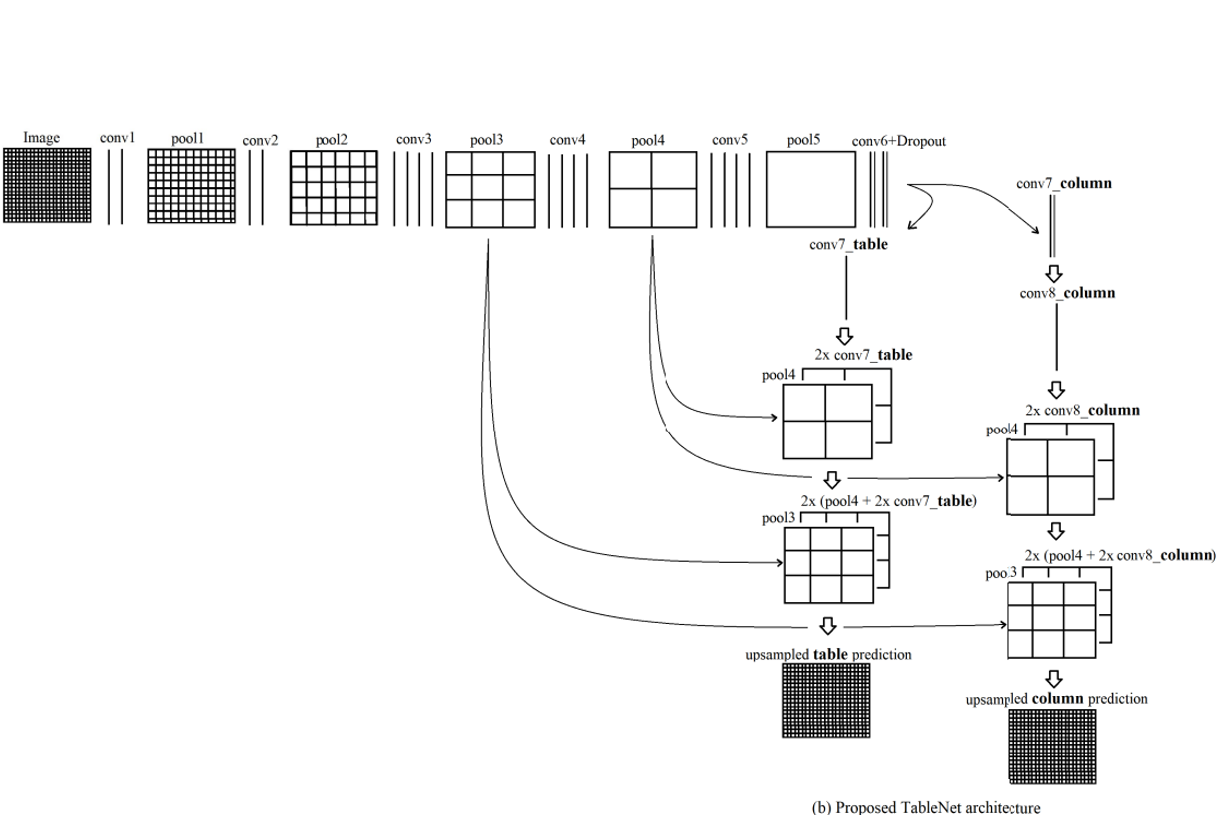

In [1]:
#gneral libraries
import os
from tqdm import tqdm
import pandas as pd
import numpy as np
import random as rn

#plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

#Image processing libraries
import cv2
from PIL import Image
from PIL import ImageOps


import struct #binary format hanling library
import xml.etree.ElementTree as ET #xml handling library

import warnings
warnings.filterwarnings("ignore")

In [2]:
files_extended = os.listdir('../input/marmot-extended/Marmot_data') #storing all the files in the marmot annotated dataset files to a list
col_files = []   #creating new list which is used to store only xml files
for file in files_extended:
    ext = file.split('.')[-1]   
    if ext=='xml':             #comparing the format of the file
        col_files.append(file)
    
col_files = set(col_files)    #type casting into set datatype cause later we need to perform some set operations      
print('no. of column annotated files', len(col_files))

no. of column annotated files 495


In [3]:
marmot_english = "../input/marmot/marmot_dataset_v1.0/data/English"
# For English folder there are two sub folders one is Negative indicating no table in the documents and Positive indicating atleast one table in the document

neg_labeled = marmot_english+'/Negative'+'/Labeled' #storing the path of labeled negative folder     
pos_labeled = marmot_english+'/Positive'+'/Labeled' #storing the path of labeled positive folder

table_neg_files = set(os.listdir(neg_labeled))           
print('no. of documents containing no table at all', len(table_neg_files))
table_pos_files = set(os.listdir(pos_labeled))
print('no. of documents containing atleast one table', len(table_pos_files))

no. of documents containing no table at all 484
no. of documents containing atleast one table 509


In [4]:
english_documents = []                     #storing all the english documents paths in one list
for file in table_neg_files:
    english_documents.append(neg_labeled+'/'+file)
    
for file in table_pos_files:
    english_documents.append(pos_labeled+'/'+file)

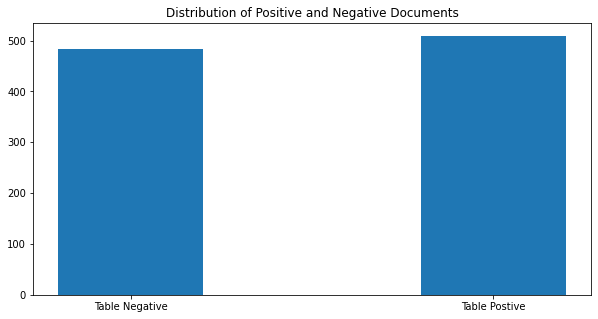

In [5]:
#plotting the distribution of positive and negative classes

fig = plt.figure(figsize = (10, 5))
x = ['Table Negative', 'Table Postive']
y = [len(table_neg_files), len(table_pos_files)]
plt.bar(x, y,width = 0.4)
plt.title('Distribution of Positive and Negative Documents')
plt.show()

Observations:
1. The dataset is a balanced one.
2. The no. of column annotated files are less than the Table positive files. 
3. Find out which of the table positive documents does not have columns.

In [6]:
#finding the difference between column annotated documents and table positive documnets
col_pos = col_files.difference(table_pos_files)
col_pos

{'10.1.1.1.xml'}

Above '10.1.1.1.xml' file is a duplicate xml file of 10.1.1.1.2031_24.bmp where '10.1.1.1.2031_24.xml' already exists. Hence we can discard this file

In [7]:
#finding the difference between table positive documents and column annotated documents
pos_col = table_pos_files.difference(col_files)
pos_col

{'10.1.1.1.2010_5.xml',
 '10.1.1.1.2076_73.xml',
 '10.1.1.1.2107_9.xml',
 '10.1.1.100.2006_12.xml',
 '10.1.1.100.293_25.xml',
 '10.1.1.100.293_47.xml',
 '10.1.1.120.1540_16.xml',
 '10.1.1.120.1540_21.xml',
 '10.1.1.160.585_35.xml',
 '10.1.1.160.585_36.xml',
 '10.1.1.160.669_3.xml',
 '10.1.1.160.677_2.xml',
 '10.1.1.6.2367_13.xml',
 '10.1.1.7.2174_3.xml',
 '10.1.1.7.2174_8.xml'}

There are about 15 documnets in containing atleast one table and no columns at all

### Reference: https://stackoverflow.com/a/58521586

In [8]:
#extracting table co-ordinates from the xml files
def get_table_bbox(table_xml_path,  new_image_shape):
    
    '''It extracts table co-ordinates from xml format adjusted to the new image shape'''

    tree = ET.parse(table_xml_path)
    root = tree.getroot()

    #cropbox is display area of the page i.e. size of the original image
    px0, py1, px1, py0 = list(map(lambda x: struct.unpack('!d', bytes.fromhex(x))[0], root.get("CropBox").split())) #converting hexadecimal string into co-ordinates
    pw = abs(px1 - px0)     #width of the original image      
    ph = abs(py1 - py0)    #height of the original image

    table_bboxes = []

    for table in root.findall(".//Composite[@Label='TableBody']"):  #for each table in the given image
        x0p, y0m, x1p,y1m  = list(map(lambda x: struct.unpack('!d', bytes.fromhex(x))[0], table.get("BBox").split())) #converting hexadecimal string into co-ordinates
        
        #adjusting the table boundaries with respect to the new image size
        x0 = round(new_image_shape[1]*(x0p - px0)/pw)   
        x1 = round(new_image_shape[1]*(x1p - px0)/pw)
        y0 = round(new_image_shape[0]*(py1 - y0m)/ph)
        y1 = round(new_image_shape[0]*(py1 - y1m)/ph)
        
        bbox = (x0, y0, x1, y1)       #tuples are immutable
        
        table_bboxes.append(bbox)
    return table_bboxes

Layout description of a page in a document is stored as tree structure, where the leaves are characters, images and paths, and the root is the whole page. Internal nodes include textlines, paragraphs, tables etc.
1. The lines are represented as HexDouble i.e. Double value stored in hexadecimal to prevent loss of precision.
2. The whole document is divided into a tree structure where characters, image and path are leaf nodes of the tree. Leaf represents the atomic object in the page
3. There are two object types: physical type and layout type
4. Physical type consists of Leaf objects and path objects
5. Layout type consists of content objects.

In [9]:
#extracting column co-ordinates if there is single table present with two or more columns
def get_col_bbox(column_xml_path, act_img_shape, new_image_shape, table_bboxes):
    
    '''For a givne xml file from Marmot extended dataset, it will return the bounding box co-ordinates of columns'''
    
    tree = ET.parse(column_xml_path)
    root = tree.getroot()
    
    #grouping all the xmins, xmaxs, ymins and ymaxs into separate lists
    xmins = [round(int(coord.text) * new_image_shape[1] / act_img_shape[1]) for coord in root.findall("./object/bndbox/xmin")]
    xmaxs = [round(int(coord.text) * new_image_shape[1] / act_img_shape[1]) for coord in root.findall("./object/bndbox/xmax")]
    ymins = [round(int(coord.text) * new_image_shape[0] / act_img_shape[0]) for coord in root.findall("./object/bndbox/ymin")]
    ymaxs = [round(int(coord.text) * new_image_shape[0] / act_img_shape[0]) for coord in root.findall("./object/bndbox/ymax")]

    col_bbox = [] #this list consists of co-ordinates i.e. a tuple of (xmin, ymin, xmax, ymax)
    
    for x_min, y_min, x_max, y_max in zip(xmins,ymins,xmaxs,ymaxs): #each bounding box is cornered by the intersections of 4 lines x_min, y_min, x_max, y_max
        bbox = (x_min, y_min, x_max, y_max)                        # x_max-x_min is the width of the image and y_max-y_min is the height of the image 
        col_bbox.append(bbox)                                     #tupples are immutable
    
    #we will approximate the table size based on columns co-ordinates with some threshold 
    if len(table_bboxes) == 0:
        thresh = 3
        x_min = min([x[0] for x in col_bbox]) - thresh 
        y_min = min([x[1] for x in col_bbox]) - thresh 
        x_max = max([x[2] for x in col_bbox]) + thresh  
        y_max = max([x[3] for x in col_bbox]) + thresh 
        
        table_bboxes = [(x_min, y_min, x_max, y_max)]
    
    return col_bbox, table_bboxes

In [10]:
# using the co-ordinates extracted we are creating a mask
def create_mask(new_image_shape, bboxes = None):
    
    '''For a given image size and bounding boxes it will returns mask images'''
    
    mask = np.zeros(new_image_shape, dtype=np.uint8)   #initializing an numpy array with the size of (new_h, new_w)
    
    
    if bboxes is None or len(bboxes)==0:             #if no bounding box is passed then dark image is returned
         return Image.fromarray(mask)
    
    for box in bboxes:                              #filling the bounding box with bright color against dark background
        mask[box[1]:box[3], box[0]:box[2]] = 255
    
    return Image.fromarray(mask)

In [11]:
def display_samples(new_image_shape, image_path, table_xml_path=None, column_xml_path=None):
    '''It displays the samples of an image along with its corresponding Table and column masks'''
    
    image = Image.open(image_path)
    width, height = image.size
    act_image_shape = (height, width)
    image = image.resize(new_image_shape)
    
    #convert into 3 channel image if image is 1 channel
    if image.mode != 'RGB':
        image = image.convert("RGB")
    
    if table_xml_path:
        table_bboxes = get_table_bbox(table_xml_path, new_image_shape)
    else:
        table_bboxes = []
    
    if column_xml_path:
        col_bboxes, table_bboxes = get_col_bbox(column_xml_path, act_image_shape, new_image_shape, table_bboxes)
    else:
        col_bboxes = []
        
    
    table_mask = create_mask(new_image_shape, table_bboxes)
    col_mask = create_mask(new_image_shape, col_bboxes)
        
        
    image_temp = np.array(image).copy()
    
    if table_bboxes or col_bboxes:
        for bbox in table_bboxes:
            cv2.rectangle(image_temp, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (0, 255, 0), 2)
            
        for bbox in col_bboxes:
            cv2.rectangle(image_temp, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (255, 255, 0), 2)
            
    f, ax = plt.subplots(1,4, figsize = (30,20))
    ax[0].imshow(image)
    ax[0].set_title('Original Image')
    ax[1].imshow(image_temp)
    ax[1].set_title('Bounding Boxes')
    ax[2].imshow(table_mask)
    ax[2].set_title('Table Mask')
    ax[3].imshow(np.array(col_mask))
    ax[3].set_title('Col_Mask')
    plt.show()

# Example 1 : Table Negative Document 

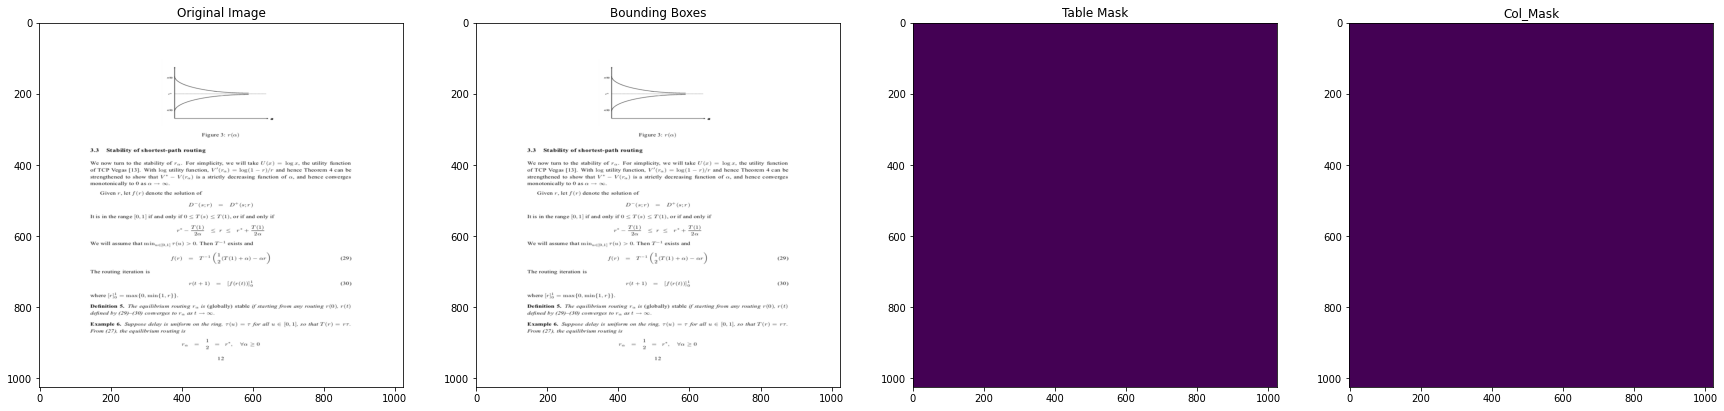

In [12]:
new_image_shape = (1024, 1024)   #the input_shape of the table net must be resized to (1024,1024)
display_samples(new_image_shape, image_path='../input/marmot/marmot_dataset_v1.0/data/English/Negative/Raw/10.1.1.1.2005_12.bmp')

# Example 2 : Table positive document with no columns

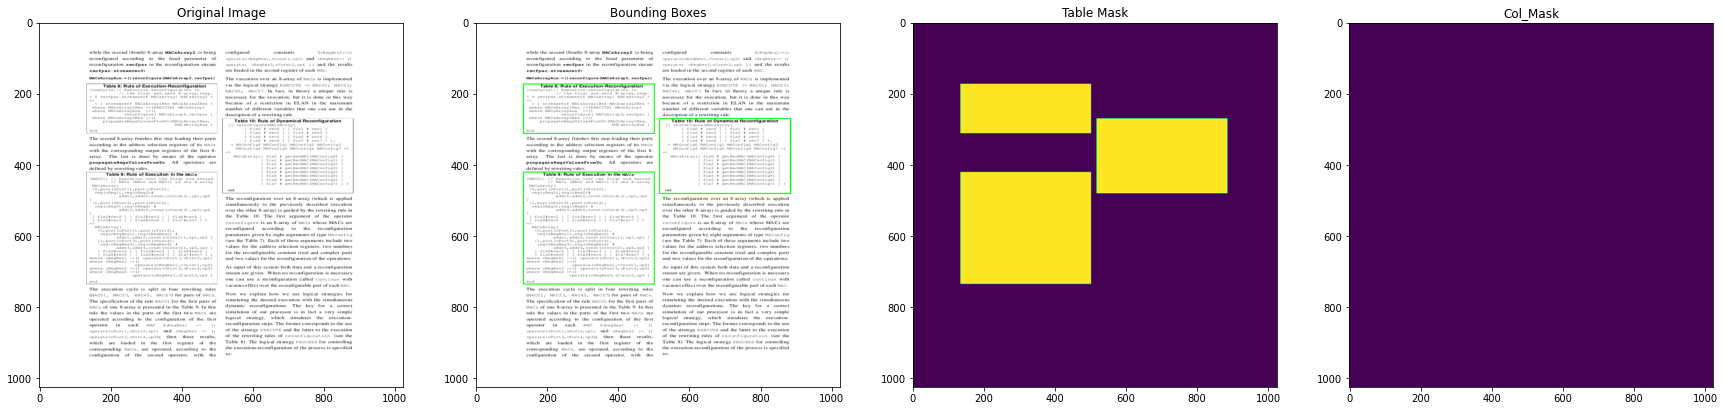

In [13]:
display_samples(new_image_shape, image_path='../input/marmot/marmot_dataset_v1.0/data/English/Positive/Raw/10.1.1.7.2174_8.bmp', 
               table_xml_path = '../input/marmot/marmot_dataset_v1.0/data/English/Positive/Labeled/10.1.1.7.2174_8.xml')

# Example 3 : Table positive document along with column structure

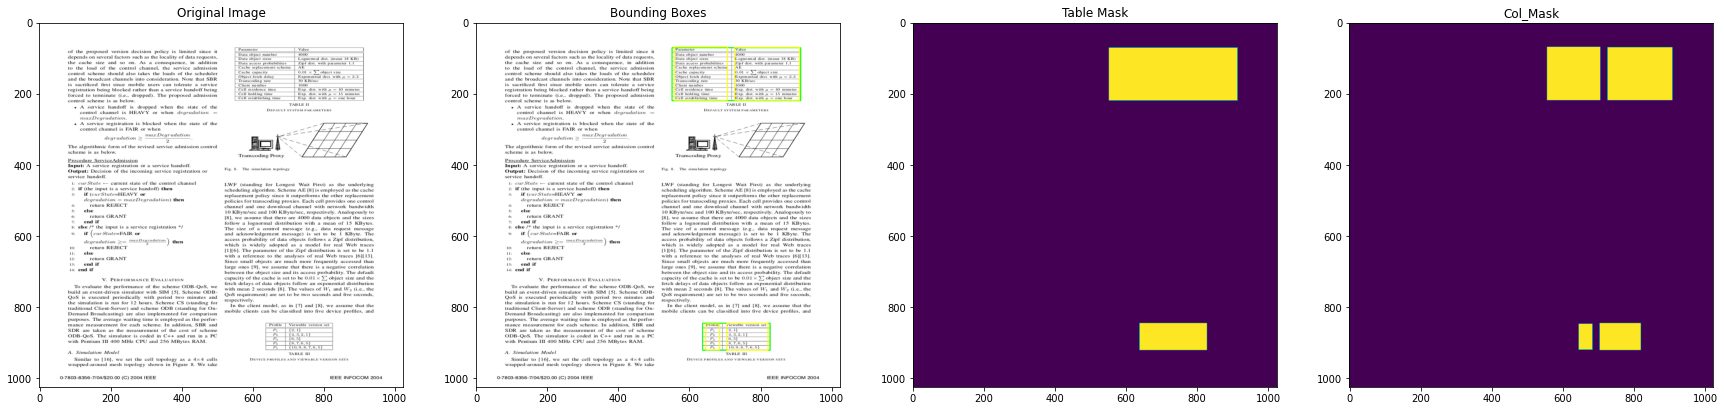

In [14]:
display_samples(new_image_shape, image_path='../input/marmot/marmot_dataset_v1.0/data/English/Positive/Raw/10.1.1.1.2018_8.bmp', 
               table_xml_path = '../input/marmot/marmot_dataset_v1.0/data/English/Positive/Labeled/10.1.1.1.2018_8.xml',
               column_xml_path = '../input/marmot-extended/Marmot_data/10.1.1.1.2018_8.xml')

# Example 4: Table approximation using Column Bounding Boxes

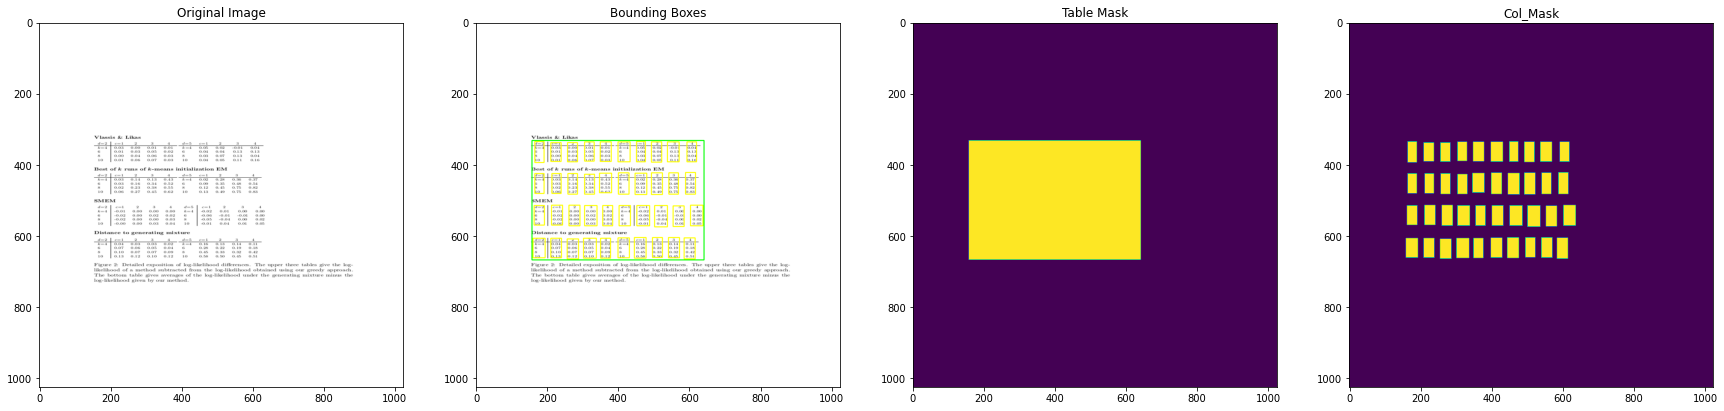

In [15]:
display_samples(new_image_shape, image_path='../input/marmot/marmot_dataset_v1.0/data/English/Positive/Raw/10.1.1.100.303_8.bmp', 
               table_xml_path = '../input/marmot/marmot_dataset_v1.0/data/English/Positive/Labeled/10.1.1.100.303_8.xml',
               column_xml_path = '../input/marmot-extended/Marmot_data/10.1.1.100.303_8.xml')

# Data Preprocessing
1. Input image is converted into GreyScale and again converted back into RGB with 3 channels Depth. This process removes the colors in the document which for the task of table detection and structure detection is treated as noise.
2. Image Histogram Equalization is performed to improve the contrast of the Input Image.
3. Then the Image is resized to (1024, 1024)
4. Finally the Image is normalized to remove highlighted regions, shadows and make that object easier to detect.

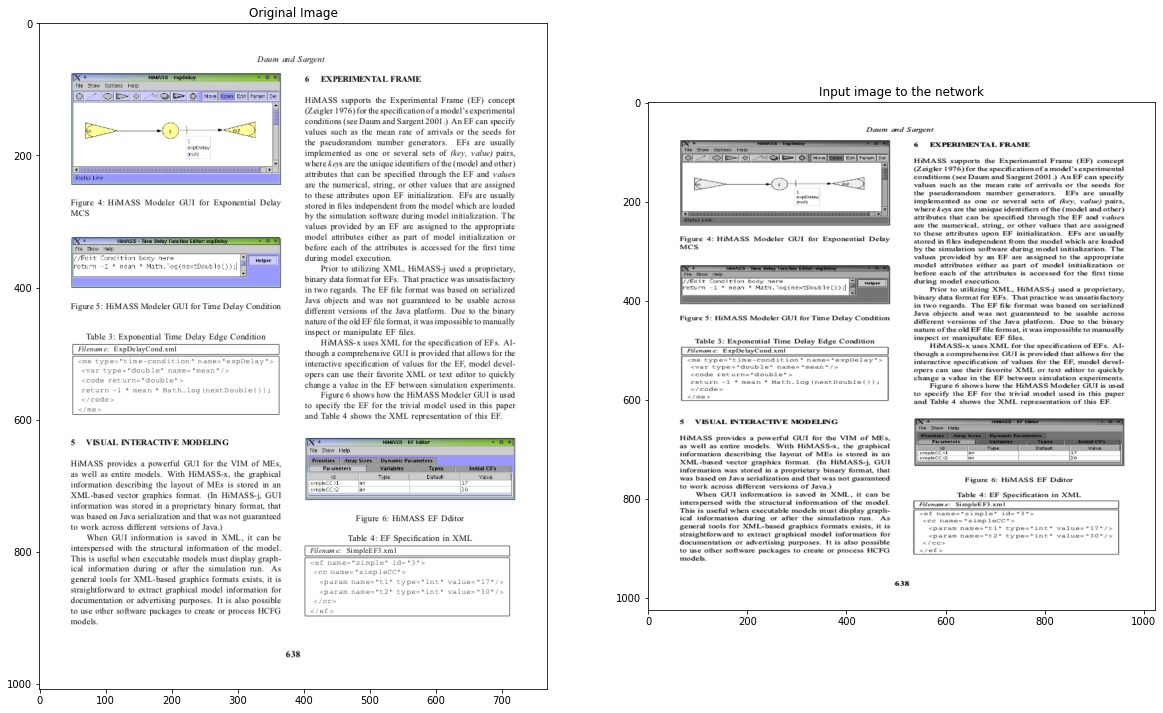

In [16]:
#https://en.wikipedia.org/wiki/Histogram_equalization
image_original = Image.open('../input/marmot/marmot_dataset_v1.0/data/English/Positive/Raw/10.1.1.1.2010_5.bmp')

image_rgb = image_original.convert('L').convert('RGB')    #converting the input image into greyscale and again into RGB to remove the different colors of the image.
image_rgb = ImageOps.equalize(image_rgb, mask=None) #histogram equilization
image_rgb = image_rgb.resize(new_image_shape)    #resizing Image to new shape 

norm_rgb = np.array(image_rgb)/255.0   #normalizing

fig, ax = plt.subplots(1,2, figsize = (20,15))

ax[0].imshow(np.array(image_original))
ax[0].set_title('Original Image')
ax[1].imshow(norm_rgb)
ax[1].set_title('Input image to the network')
plt.show()

# # Generating table and column mask which are later to be used as labels and storing their paths in a DataFrame

In [17]:
marmot_extended = '../input/marmot-extended/Marmot_data'
marmot_preprocessed = 'marmot_preprocessed
images = os.path.join(marmot_preprocessed, 'image_processed')
table_masks = os.path.join(marmot_preprocessed, 'table_mask')
column_masks = os.path.join(marmot_preprocessed, 'col_mask')

os.makedirs(marmot_preprocessed, exist_ok = True)
os.makedirs(images, exist_ok = True)
os.makedirs(table_masks, exist_ok = True)
os.makedirs(column_masks, exist_ok = True)

In [18]:
preprocessed_data = []


for table_path in tqdm(english_documents):             #for every table xml path in the english documents
    
    xml_name=os.path.basename(table_path)             #saving the xml file name
    image_path = table_path.replace('xml', 'bmp')     #replacing the extension
    image_path = image_path.replace('Labeled', 'Raw') #replacing the directory 
    image = Image.open(image_path)    

    width, height = image.size
    act_image_shape = (height, width)
    
    #image preprocessing
    image = image.convert('L').convert('RGB')       #converting the input image into greyscale and again into RGB to remove the different colors of the image.
    image = ImageOps.equalize(image, mask=None)     #histogram equilization
    image = image.resize(new_image_shape)           #resizing Image to new shape    
    
    table_bboxes, col_bboxes = [], []
    
    column_path = marmot_extended+'/'+xml_name            #creating the column xml path
    table_bboxes = get_table_bbox(table_path, new_image_shape) #assingning table boundary boxes co-ordinates
    if os.path.exists(column_path):
        col_bboxes, table_bboxes = get_col_bbox(column_path, act_image_shape, new_image_shape, table_bboxes) #assingning the column boundary co-ordinates
    else:
        col_bboxes = []    #if the table has no columns
        
    #generating masks
    table_mask = create_mask(new_image_shape, table_bboxes)
    col_mask = create_mask(new_image_shape, col_bboxes) 
    
    #saving the masks
    save_image_path = os.path.join(images, xml_name.replace('xml', 'jpeg'))
    save_table_mask_path = os.path.join(table_masks, xml_name[:-3] + 'jpeg')
    save_col_mask_path = os.path.join(column_masks, xml_name[:-3] + 'jpeg')
    
    image.save(save_image_path)
    table_mask.save(save_table_mask_path)
    col_mask.save(save_col_mask_path)
        
    #add data to dataframe
    len_table = len(table_bboxes)
    len_cols = len(col_bboxes)

    value = (save_image_path, save_table_mask_path, save_col_mask_path, height, width, int(len_table != 0), len_table, len_cols, table_bboxes, col_bboxes)
        
    preprocessed_data.append(value)

100%|██████████| 993/993 [01:33<00:00, 10.57it/s]


In [19]:
column_names = ['image_path','table_mask_path','col_mask_path','original_height','original_width','hasTable','table_count','col_count','table_bboxes','col_bboxes']
df = pd.DataFrame(preprocessed_data, columns=column_names)
df.tail()

,image_path,table_mask_path,col_mask_path,original_height,original_width,hasTable,table_count,col_count,table_bboxes,col_bboxes
988,marmot_preprocessed/image/10.1.1.8.2156_5.jpeg,marmot_preprocessed/table_mask/10.1.1.8.2156_5...,marmot_preprocessed/col_mask/10.1.1.8.2156_5.jpeg,1056,816,1,3,18,"[(204, 118, 806, 291), (204, 337, 806, 510), (...","[(238, 120, 315, 290), (369, 123, 429, 288), (..."
989,marmot_preprocessed/image/10.1.1.6.2346_5.jpeg,marmot_preprocessed/table_mask/10.1.1.6.2346_5...,marmot_preprocessed/col_mask/10.1.1.6.2346_5.jpeg,1056,816,1,2,14,"[(231, 200, 790, 308), (241, 471, 784, 584)]","[(247, 202, 333, 308), (361, 201, 404, 305), (..."
990,marmot_preprocessed/image/10.1.1.6.2255_4.jpeg,marmot_preprocessed/table_mask/10.1.1.6.2255_4...,marmot_preprocessed/col_mask/10.1.1.6.2255_4.jpeg,1056,816,1,1,6,"[(514, 807, 946, 898)]","[(526, 828, 576, 899), (604, 832, 636, 892), (..."
991,marmot_preprocessed/image/10.1.1.8.2185_13.jpeg,marmot_preprocessed/table_mask/10.1.1.8.2185_1...,marmot_preprocessed/col_mask/10.1.1.8.2185_13....,1056,816,1,1,3,"[(241, 541, 787, 682)]","[(241, 558, 262, 680), (272, 558, 330, 677), (..."
992,marmot_preprocessed/image/10.1.1.190.2735_45.jpeg,marmot_preprocessed/table_mask/10.1.1.190.2735...,marmot_preprocessed/col_mask/10.1.1.190.2735_4...,1056,816,1,1,4,"[(102, 489, 921, 899)]","[(107, 504, 176, 894), (203, 506, 341, 907), (..."


# EDA

In [20]:
df['hasTable'].value_counts()

1    503
0    490
Name: hasTable, dtype: int64

In [21]:
# documents containing columns without any tables 
df[(df['table_count']==0) & (df['col_count']!=0)]

,image_path,table_mask_path,col_mask_path,original_height,original_width,hasTable,table_count,col_count,table_bboxes,col_bboxes


There are no documents with having column masks and no Table masks. We approximated the table bounding box with threshold = 3 pixels in the get_col_bbox function

In [22]:
#documents with tables but no columns
df[(df['hasTable']==1) & (df['col_count']==0)]

,image_path,table_mask_path,col_mask_path,original_height,original_width,hasTable,table_count,col_count,table_bboxes,col_bboxes
9,marmot_preprocessed/image/10.1.1.1.2110_4.jpeg,marmot_preprocessed/table_mask/10.1.1.1.2110_4...,marmot_preprocessed/col_mask/10.1.1.1.2110_4.jpeg,1123,794,1,1,0,"[(522, 66, 954, 188)]",[]
336,marmot_preprocessed/image/10.1.1.6.2382_5.jpeg,marmot_preprocessed/table_mask/10.1.1.6.2382_5...,marmot_preprocessed/col_mask/10.1.1.6.2382_5.jpeg,1056,816,1,1,0,"[(136, 125, 509, 272)]",[]
412,marmot_preprocessed/image/10.1.1.1.2113_4.jpeg,marmot_preprocessed/table_mask/10.1.1.1.2113_4...,marmot_preprocessed/col_mask/10.1.1.1.2113_4.jpeg,1008,768,1,1,0,"[(547, 510, 949, 901)]",[]
481,marmot_preprocessed/image/10.1.1.1.2092_101.jpeg,marmot_preprocessed/table_mask/10.1.1.1.2092_1...,marmot_preprocessed/col_mask/10.1.1.1.2092_101...,864,576,1,1,0,"[(140, 95, 884, 215)]",[]
548,marmot_preprocessed/image/10.1.1.7.2174_8.jpeg,marmot_preprocessed/table_mask/10.1.1.7.2174_8...,marmot_preprocessed/col_mask/10.1.1.7.2174_8.jpeg,1056,816,1,3,0,"[(133, 171, 501, 310), (133, 419, 501, 734), (...",[]
565,marmot_preprocessed/image/10.1.1.160.669_3.jpeg,marmot_preprocessed/table_mask/10.1.1.160.669_...,marmot_preprocessed/col_mask/10.1.1.160.669_3....,1123,793,1,1,0,"[(65, 183, 936, 850)]",[]
682,marmot_preprocessed/image/10.1.1.1.2010_5.jpeg,marmot_preprocessed/table_mask/10.1.1.1.2010_5...,marmot_preprocessed/col_mask/10.1.1.1.2010_5.jpeg,1008,768,1,2,0,"[(68, 494, 484, 602), (536, 804, 949, 912)]",[]
707,marmot_preprocessed/image/10.1.1.7.2174_3.jpeg,marmot_preprocessed/table_mask/10.1.1.7.2174_3...,marmot_preprocessed/col_mask/10.1.1.7.2174_3.jpeg,1056,816,1,1,0,"[(516, 611, 885, 734)]",[]
724,marmot_preprocessed/image/10.1.1.1.2107_9.jpeg,marmot_preprocessed/table_mask/10.1.1.1.2107_9...,marmot_preprocessed/col_mask/10.1.1.1.2107_9.jpeg,1056,816,1,2,0,"[(138, 622, 693, 891), (138, 99, 693, 440)]",[]


# Image Heights & Widths

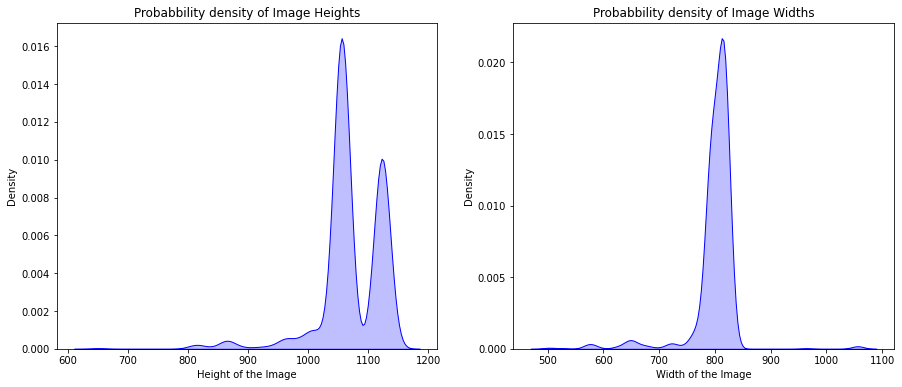

In [23]:
fig, ax = plt.subplots(1,2, figsize=(15,6))
sns.kdeplot(df['original_height'], color='b', shade=True, ax=ax[0])
ax[0].set_title('Probabbility density of Image Heights')
ax[0].set_xlabel('Height of the Image')
ax[0].set_ylabel('Density')

sns.kdeplot(df['original_width'], color='b', shade=True, ax=ax[1])
ax[1].set_title('Probabbility density of Image Widths')
ax[1].set_xlabel('Width of the Image')
ax[1].set_ylabel('Density')

plt.show()

## Observations:
1. Most of the Images heights are in the range(1000, 1200) pixels. The distribution is right skewed.
2. Most of the Images widths are centered around 800 pixels. This distribution is some what symmetric.

# Table Counts, Heights, Widhts

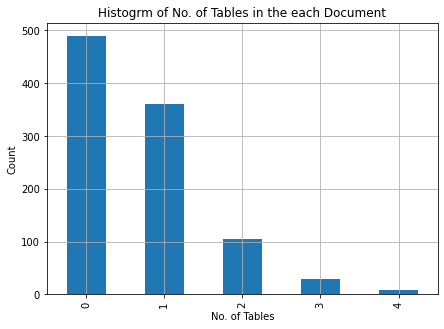

In [24]:
plt.figure(figsize=(7,5))
df['table_count'].value_counts().plot(kind='bar')
plt.title('Histogrm of No. of Tables in the each Document')
plt.ylabel('Count')
plt.xlabel('No. of Tables')
plt.grid()

In [25]:
table_heights = []
table_widths = []
for boxes in df[df['hasTable']==1]['table_bboxes']:   #for each document having atleast one table 
    for box in boxes:
        table_heights.append(box[3]-box[1])
        table_widths.append(box[2]-box[0])

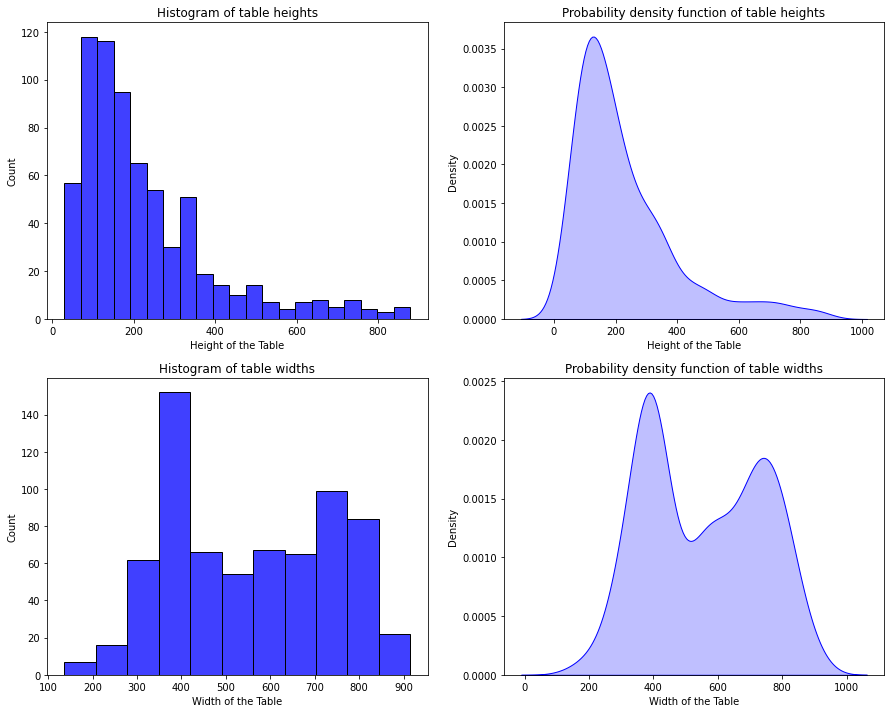

In [26]:
fig, ax = plt.subplots(2,2, figsize=(15,12))

sns.histplot(table_heights, color='b', ax=ax[0][0])
ax[0][0].set_title('Histogram of table heights')
ax[0][0].set_xlabel('Height of the Table')
ax[0][0].set_ylabel('Count')

sns.kdeplot(table_heights, color='b', ax=ax[0][1], shade=True)
ax[0][1].set_title('Probability density function of table heights')
ax[0][1].set_xlabel('Height of the Table')
ax[0][1].set_ylabel('Density')

sns.histplot(table_widths, color='b', ax=ax[1][0])
ax[1][0].set_title('Histogram of table widths')
ax[1][0].set_xlabel('Width of the Table')
ax[1][0].set_ylabel('Count')

sns.kdeplot(table_widths, color='b', ax=ax[1][1], shade=True)
ax[1][1].set_title('Probability density function of table widths')
ax[1][1].set_xlabel('Width of the Table')
ax[1][1].set_ylabel('Density')

plt.show()

## Observations:
1. As the no. of table per document is high the no. of such documnets are very low.
2. The peak of the table height pdf funciton is around 100 indicating that majority of the tables are of 100 pixels height but the distribution is left skewed i.e. most of the tables are below 400 pixels of height.
3. The peask of the table width pdf function is around 400 indicating that majority of the tables are of 400 pixels width but the distribution is some what uniform and most of the table width falls between (300, 800) pixels.

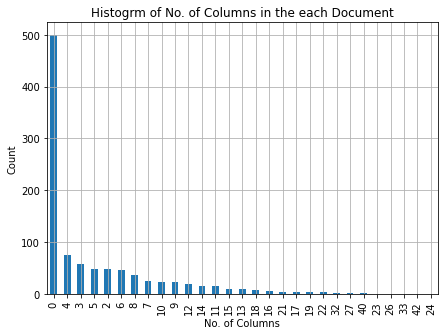

In [27]:
plt.figure(figsize=(7,5))
df['col_count'].value_counts().plot(kind='bar')
plt.title('Histogrm of No. of Columns in the each Document')
plt.ylabel('Count')
plt.xlabel('No. of Columns')
plt.grid()

In [28]:
col_heights = []
col_widths = []
for boxes in df[df['hasTable']==1]['col_bboxes']:   #for each document having atleast one table
    for box in boxes:
        col_heights.append(box[3]-box[1])
        col_widths.append(box[2]-box[0])

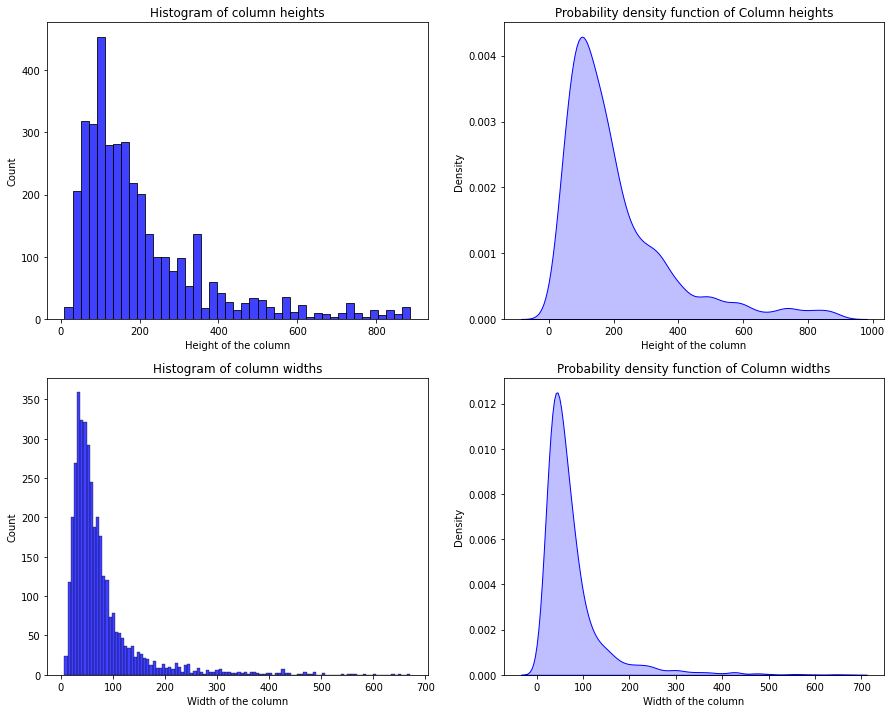

In [29]:
fig, ax = plt.subplots(2,2, figsize=(15,12))

sns.histplot(col_heights, color='b', ax=ax[0][0])
ax[0][0].set_title('Histogram of column heights')
ax[0][0].set_xlabel('Height of the column')
ax[0][0].set_ylabel('Count')

sns.kdeplot(col_heights, color='b', ax=ax[0][1], shade=True)
ax[0][1].set_title('Probability density function of Column heights')
ax[0][1].set_xlabel('Height of the column')
ax[0][1].set_ylabel('Density')

sns.histplot(col_widths, color='b', ax=ax[1][0])
ax[1][0].set_title('Histogram of column widths')
ax[1][0].set_xlabel('Width of the column')
ax[1][0].set_ylabel('Count')

sns.kdeplot(col_widths, color='b', ax=ax[1][1], shade=True)
ax[1][1].set_title('Probability density function of Column widths')
ax[1][1].set_xlabel('Width of the column')
ax[1][1].set_ylabel('Density')

plt.show()